# Solar Data Exploration

Author: Sayantan Mitra<br>
Chief Data Scientist, Compton & Wendler<br>
Ph.D. candidate, Baylor College of Medicine

<div style="text-align: right">
'The Nation that leads in renewable energy will be the nation that leads the world' —James Cameron </div>

The 21st Century has borne witness to severe global environmental problems including polar ice-cap melting, frequent earthquakes in southeast Asia, and consequent tsunamis. Scientists have connected these problems to climate change. Across the globe, people have become more aware of the need for clean energy. The sun has been and will always remain the largest source of energy for the planet. Solar power has been harnessed in the last few decades but people have hesitated to adopt this capacity on a mass scale. Concerns range from solar energy's applicability and safety for residential homes to the amount of solar panels required to replace conventional energy sources.

In this project, I take a step toward demystifying the size of solar panels needed to completely eliminate reliance on traditional electricity. There are a lot of factors involved in efficient solar energy production and we will comprehensively address them throughout the project. Data for this project has been collected from [National Renewable Energy Laboratory](https://openpv.nrel.gov/search).

### ► <span  style="color:blue; font-size:15px"> Objective 1: Predict size of solar panels for residential setting
### ► <span  style="color:blue; font-size:15px"> Objective 2: Predict cost of solar panels for residential setting</span>

Here is a video to learn how home solar panels work! 

[![How Home Solar Panel Works](http://img.youtube.com/vi/m6UgO6-HELc/0.jpg)](http://www.youtube.com/watch?v=m6UgO6-HELc) 

## Hypothesis:
**Size and cost of solar panels depends on amount of energy consumption**
<BR>
Explanation:
The size of solar panels (unit not in dimernsion , but kw i.e. amount of energy it can produce) required depend on amount of energy consumption. And cost of solar panels depend on size of solar panels.

## Executive summary:
Overall, we have shown in this notebook that the size of solar panels required is highly dependent on the energy consumption (R2~0.98 for the overall model) and cost of solar panels are related to amount of energy consumption as well (R2~0.8 for the overall model) by ridge regression model.

→ Many interesting facts were discovered through EDA including California is one of the early adopters of clean energy (solar) but overall size of the solar panel installation is relatively less than other states, city of Phoenix has installed solar panels with mean highest size_kw etc.

# 1. Exploratory Data Analysis (EDA)

# 1.A. Import libraries

In [1]:
import numpy as np
import pandas as pd
import pandas_profiling as pf
from collections import Counter

# VisualiZation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

# ignore warnings
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

# 1.B. Load data 
We can have basic information of the columns and about data overall, stored in the form of a dictionary.

In [2]:
pd.options.display.max_colwidth = 100
solar_dictionary = pd.read_excel('solar_pred_datadict.xlsx', index_col='Column Names')
solar_dictionary

,Description
Column Names,
state,Which state the customer belongs
date_installed,How long ago it has been installed
incentive_prog_names,Incentive programs specific to the states
size_kw,Size of the solar panels installed in kw units (TARGET)
zipcode,customers zipcode
install_type,customers pupose of installation
installer,Installing company for solar panels
city,Which city customer belongs to
tech_1,Different types of solar panels that determins solar panel quality


In [3]:
# Features selected based on what users can know and incorportae in the app
solar = pd.read_csv('residential_solar_size_costpred.csv', 
                    usecols= ['state', 'date_installed', 'zipcode', 'install_type', 'installer', 'city',
                              'tech_1', 'county', 'annual_PV_prod', 'size_kw', 'cost'], parse_dates=['date_installed']) 
solar.head()

,state,date_installed,size_kw,zipcode,install_type,installer,city,tech_1,county,annual_PV_prod,cost
0,TX,2013-12-12,10.56,78702,residential,NaN,AUSTIN,Poly,Travis,14999.831600,30600.53
1,TX,2014-07-11,12.72,78702,residential,NaN,AUSTIN,Mono,Travis,17811.574390,40000.00
2,TX,2014-01-17,5.40,78702,residential,NaN,AUSTIN,Mono,Travis,7833.742822,22665.58
3,TX,2012-09-27,7.50,78702,residential,NaN,AUSTIN,Poly,Travis,10151.709590,28125.00
4,TX,2012-09-26,5.00,78702,residential,NaN,AUSTIN,Poly,Travis,7307.133789,19250.00


→ We are trying to predict solar panel size of residential setting. Let's check how much data we will be losing out if we only select residential data.

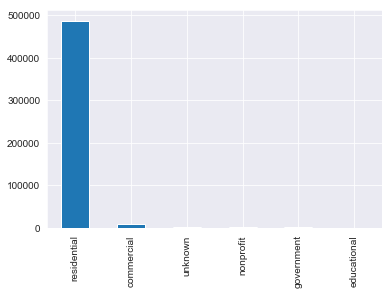

In [4]:
solar['install_type'].value_counts().plot(kind='bar'); 

We wont be losing out that much data if we only select residential setting

In [5]:
solar = solar[solar['install_type'] == 'residential']
# All residential so drop column 'install_type'
solar = solar.drop(columns=['install_type'])
solar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 487254 entries, 0 to 531937
Data columns (total 10 columns):
state             487254 non-null object
date_installed    487254 non-null datetime64[ns]
size_kw           487254 non-null float64
zipcode           487254 non-null int64
installer         425396 non-null object
city              487254 non-null object
tech_1            380238 non-null object
county            487254 non-null object
annual_PV_prod    487254 non-null float64
cost              487254 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1), object(5)
memory usage: 40.9+ MB


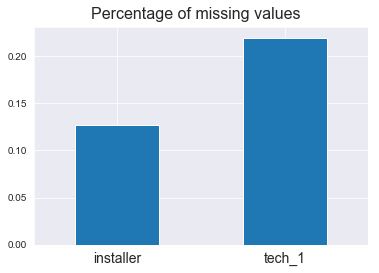

Missing values after imputation: 0


In [6]:
# Missing values specific to 3 columns
solar.isna().mean().round(3)
f,ax=plt.subplots(figsize=(6,4))
missing = solar.isna().mean()
missing[missing>0].plot.bar(ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0, fontsize=14)
f.suptitle('Percentage of missing values', fontsize=16, y=.95)
plt.show();

# impute
def impute_na(df, col):
    df[col].fillna("Unknown", inplace=True)
    
cols = ['installer', 'tech_1']
for col in cols:
    impute_na(solar, col)
print(f'Missing values after imputation: {solar.isna().sum().sum()}')

# 1.C. Feature Engineering

In [7]:
# Zipcode: extract initial numbers of zipcode to see impact on energy production if area is classified largely
solar['zipcode_1'] = solar['zipcode'].astype('str').str[:1].astype(int)
# DateTime column: extract year and month of installation
date = solar['date_installed']
solar['year'] =  date.dt.year.astype('str')
# solar_x will be a copy of the data at this stage (before taking care of cardinality)
solar_x = solar.copy()

# Divide data into train and test # Use this test as a validation set later on
solar_train, solar_val = train_test_split(solar, test_size=0.2, random_state= 0)
solar = solar_train

### Cardinality reduction

In [8]:
solar.describe(include=['O']).T

,count,unique,top,freq
state,389803,19,CA,209441
installer,389803,5967,SolarCity,90471
city,389803,7564,TUCSON,7736
tech_1,389803,12,Poly,175860
county,389803,479,Los Angeles,37372
year,389803,17,2015,142007


► Unique values in some categorical columns such as `installer`, `city`, `county`, etc. are large. Generally cardinality leads to more problems in tree based models. We will only retain the categories in a categorical column that has 1% or more appearances. The remaining categories in that column will be aggregated as `Others`. This process will be done for both the train and test set.

In [9]:
def group_levels_in_categoricals(df, threshold=0.01, min_freq=0, max_freq=np.Inf):
    df0 = df.describe(include=['O']).T
    # reduced list is name of categorical columns
    reduced_list = df0[(df0.unique < max_freq) & (df0.unique > min_freq)].reset_index()['index'].tolist()
    
    #patterns will contain list of all categories of all categorical column whose occurance is more than threshold
    patterns = []
    other = []
    for col in reduced_list:
        df_normalized = df[col].value_counts(normalize=True).reset_index()
        df_normalized.columns = ['col_name', 'normalized_value']
        filt = df_normalized['normalized_value'] > threshold
        # norm_list contains all the categories in a categorical column whose occurance is more than threshold    
        norm_list = df_normalized[filt]['col_name'].tolist()
        pattern = norm_list
        patterns.append(norm_list)
        # selecting categories that are present less than threshold
        others_list = df_normalized[~filt]['col_name'].tolist()
        other.append(others_list)
        
        if pattern != []: 
            df[col] = df[col].replace({x:'Other' for x in others_list})
        else:
            df.drop(col, inplace=True, axis=1)
    return (df, patterns, reduced_list, other)

df, patterns, reduced_list, other = group_levels_in_categoricals(solar)
# solar training set after transformation
solar.describe(include=['O']).T

,count,unique,top,freq
state,389803,12,CA,209441
installer,389803,12,Other,179175
city,389803,7,Other,354845
tech_1,389803,5,Poly,175860
county,389803,23,Other,125776
year,389803,10,2015,142007


In [10]:
# We have to keep this consistent with test data as well
def group_levels_in_categoricals_test(reduced_list, other, patterns, df_test):  
    for idx, col in enumerate(reduced_list):       
        if other[idx] != []:
            filt = df_test[col].isin(patterns[idx])
            df_test[col][~filt]='Others'
        else:
            df_test.drop(col, inplace=True, axis=1)       
    return df_test

solar_val = group_levels_in_categoricals_test(reduced_list, other, patterns, solar_val)
# solar validation set after transformation
solar_val.describe(include=['O']).T

,count,unique,top,freq
state,97451,12,CA,52433
installer,97451,12,Others,44960
city,97451,7,Others,88826
tech_1,97451,5,Poly,43976
county,97451,23,Others,31364
year,97451,10,2015,35664


# 2.A. Explore target variable 1: `size_kw`

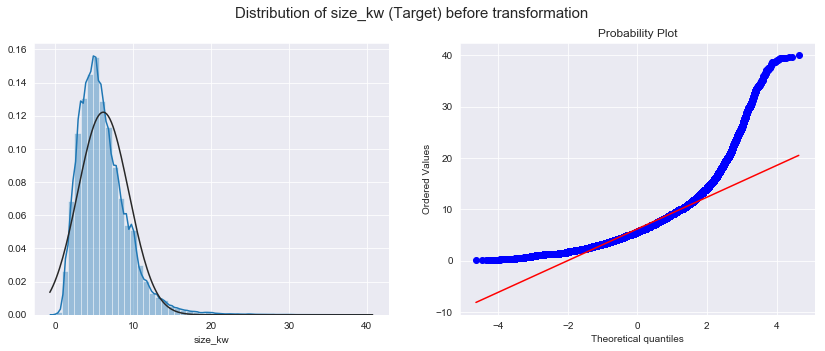

mu = 6.18 and sigma = 3.27

Skewness: 1.741199
Kurtosis: 7.050667
The target variable is right skewed. We need to transform the target before running regression.




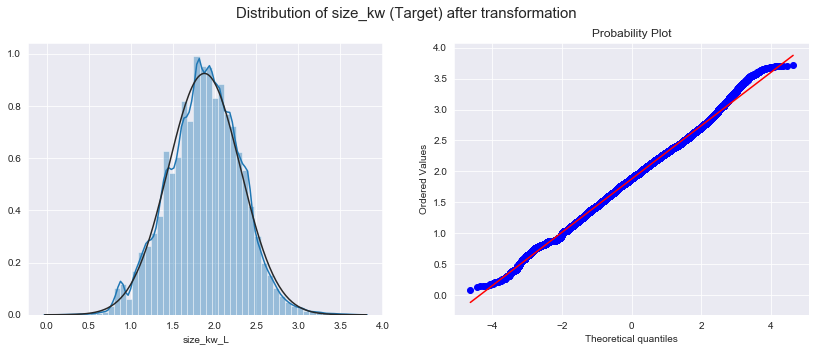


 mu = 1.88 and sigma = 0.43

Skewness: -0.040670
Kurtosis: 0.119455
After transformation target follows normal distribution.


In [11]:
import scipy.stats as st
from scipy.stats import norm, skew 
fig, axes = plt.subplots(1,2, figsize = (14,5))

# Distribution of target
sns.distplot(solar['size_kw'], fit=norm, ax=axes[0])
# QQ-plot to check normality
res = st.probplot(solar['size_kw'], plot=plt)
fig.suptitle('Distribution of size_kw (Target) before transformation', size=15)
plt.show()
# Skewness and Kurtosis
(mu, sigma) = norm.fit(solar['size_kw'])
print( 'mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
print("Skewness: %f" % solar['size_kw'].skew())
print("Kurtosis: %f" % solar['size_kw'].kurt())
print(f'The target variable is right skewed. We need to transform the target before running regression.')
print('\n')


# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
solar['size_kw_L'] = np.log1p(solar['size_kw'])
solar_val['size_kw_L'] = np.log1p(solar_val['size_kw'])
fig, axes = plt.subplots(1,2, figsize = (14,5))

#Check the new distribution 
sns.distplot(solar['size_kw_L'], fit=norm, ax=axes[0])
# QQ-plot to check normality
res = st.probplot(solar['size_kw_L'], plot=plt)
fig.suptitle('Distribution of size_kw (Target) after transformation', size=15)
plt.show()
# Skewness and Kurtosis
(mu, sigma) = norm.fit(solar['size_kw_L'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
print("Skewness: %f" % solar['size_kw_L'].skew())
print("Kurtosis: %f" % solar['size_kw_L'].kurt())
print(f'After transformation target follows normal distribution.')

Let's revisit the hypothesis that whether size of solar panels depend on anuual energy consumption

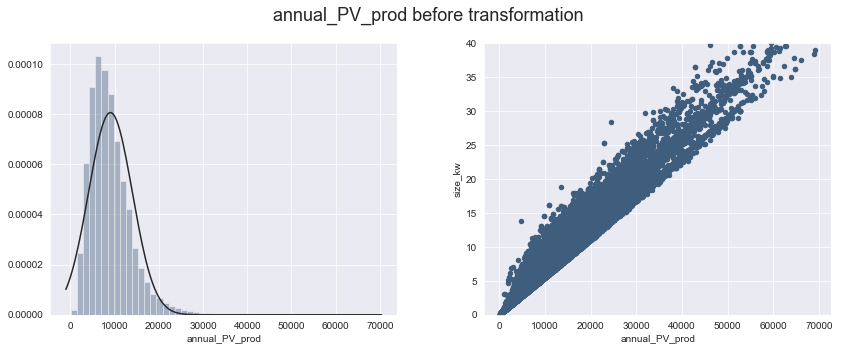

mu = 9063.65 and sigma = 4947.85

Skewness: 1.919735
Kurtosis: 8.106749


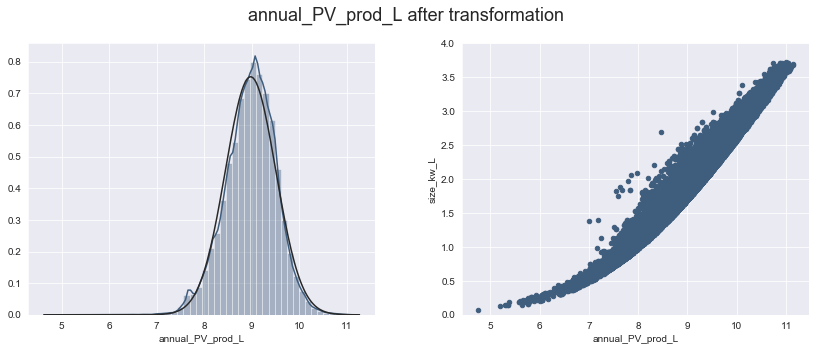

mu = 8.98 and sigma = 0.53
Skewness: -0.284697
Kurtosis: 0.586224


In [12]:
fig, axes = plt.subplots(1,2, figsize = (14,5), gridspec_kw = {'wspace':0.25, 'hspace':0.30})
# Distribution of annual_PV_prod
sns.distplot(solar['annual_PV_prod'], kde=False, fit=norm, ax=axes[0], color = '#3F5D7D')
fig.suptitle('annual_PV_prod before transformation', size=18)
solar.plot.scatter(x='annual_PV_prod', y='size_kw', ylim=(0,40), color = '#3F5D7D', ax=axes[1])
plt.show()
# Skewness and Kurtosis
(mu, sigma) = norm.fit(solar['annual_PV_prod'])
print( 'mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
print("Skewness: %f" % solar['annual_PV_prod'].skew())
print("Kurtosis: %f" % solar['annual_PV_prod'].kurt())

fig, axes = plt.subplots(1,2, figsize = (14,5), gridspec_kw = {'wspace':0.25, 'hspace':0.30})
# numpy fuction log1p applies log(1+x) to all elements of the column
solar['annual_PV_prod_L'] = np.log1p(solar['annual_PV_prod'])
solar_val['annual_PV_prod_L'] = np.log1p(solar_val['annual_PV_prod'])

# Distribution of the transformed column
sns.distplot(solar['annual_PV_prod_L'], fit=norm, ax=axes[0], color = '#3F5D7D')
fig.suptitle('annual_PV_prod_L after transformation', size=18)
solar.plot.scatter(x='annual_PV_prod_L', y='size_kw_L', ylim=(0,4), color = '#3F5D7D', ax=axes[1])
plt.show()
# Skewness and Kurtosis
(mu, sigma) = norm.fit(solar['annual_PV_prod_L'])
print( 'mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))
print("Skewness: %f" % solar['annual_PV_prod_L'].skew())
print("Kurtosis: %f" % solar['annual_PV_prod_L'].kurt())

# 2.B. Explore target variable 2: `Cost`

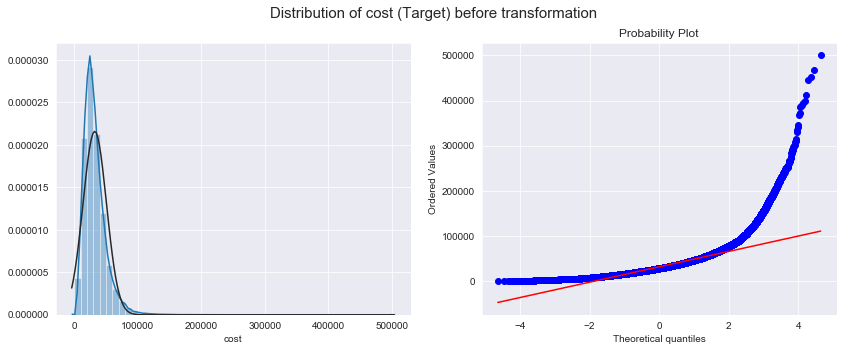

mu = 32246.66 and sigma = 18485.61

Skewness: 2.577766
Kurtosis: 19.322154




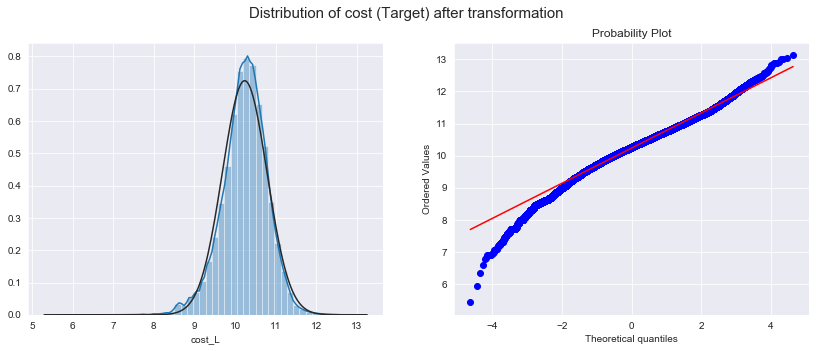


 mu = 10.24 and sigma = 0.55

Skewness: -0.376414
Kurtosis: 0.946624


In [13]:
import scipy.stats as st
from scipy.stats import norm, skew # for some statistics
#from scipy.stats import boxcox
fig, axes = plt.subplots(1,2, figsize = (14,5))

# Distribution of target
sns.distplot(solar['cost'], fit=norm, ax=axes[0])
# QQ-plot to check normality
res = st.probplot(solar['cost'], plot=plt)
fig.suptitle('Distribution of cost (Target) before transformation', size=15)
plt.show()
# Skewness and Kurtosis
(mu, sigma) = norm.fit(solar['cost'])
print( 'mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
print("Skewness: %f" % solar['cost'].skew())
print("Kurtosis: %f" % solar['cost'].kurt())
print('\n')

# We can use log transformation or box-cox transformation
solar['cost_L'] = np.log1p(solar['cost'])
solar_val['cost_L'] = np.log1p(solar_val['cost'])
fig, axes = plt.subplots(1,2, figsize = (14,5))
#Check the new distribution 
sns.distplot(solar['cost_L'], fit=norm, ax=axes[0])
# QQ-plot to check normality
res = st.probplot(solar['cost_L'], plot=plt)
fig.suptitle('Distribution of cost (Target) after transformation', size=15)
plt.show()
# Skewness and Kurtosis
(mu, sigma) = norm.fit(solar['cost_L'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
print("Skewness: %f" % solar['cost_L'].skew())
print("Kurtosis: %f" % solar['cost_L'].kurt())

Let's revisit the hypothesis that whether cost of solar panels depend on anuual energy consumption

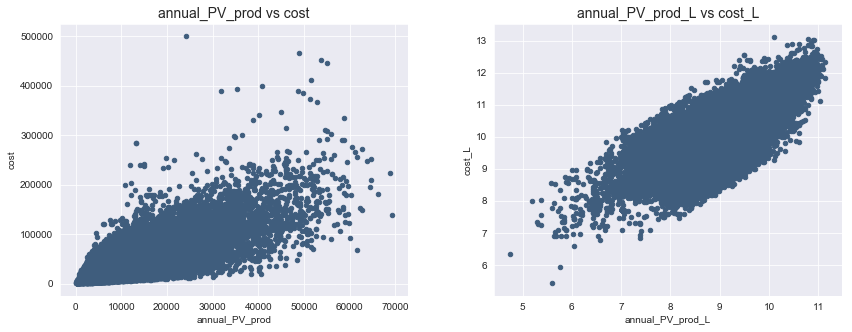

In [14]:
fig, axes = plt.subplots(1,2, figsize = (14,5), gridspec_kw = {'wspace':0.25, 'hspace':0.30})
# Relationship of untransformed columns
solar.plot.scatter(x='annual_PV_prod', y='cost', color = '#3F5D7D', ax=axes[0])#, ylim=(0,40)
axes[0].set_title('annual_PV_prod vs cost', size=14)

# Relationship between the transformed column
solar.plot.scatter(x='annual_PV_prod_L', y='cost_L', color = '#3F5D7D', ax=axes[1])
axes[1].set_title('annual_PV_prod_L vs cost_L', size=14)
plt.show()

**Lot more detailed EDA in the explanatory notebooks <br>
Take away points:**<br>
→ Overall, the number of installations have increased over the years. <br>
→ Overall, the number of installations and the size of installations have increased over the years in different states. <br>
→ Although CA has the most installations, the mean size of solar panel installation in CA is less than most of the states.<br>
→ The most popular solar panels used for residential setting are Poly.<br>
→ Counties like LA and Maricopa have installed the most solar panels. <br>
→ CA was one of the early adopters of clean energy or solar panels.<br>
→ The city of Phoenix has installed solar panels with mean highest size_kw.<br>

# 2.C. Outlier Detection

In [15]:
# Outlier detection
from collections import Counter
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 3 * IQR
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )  
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(solar,1,['size_kw_L', 'annual_PV_prod_L'])
solar.loc[Outliers_to_drop]

,state,date_installed,size_kw,zipcode,installer,city,tech_1,county,annual_PV_prod,cost,zipcode_1,year,size_kw_L,annual_PV_prod_L,cost_L


In [16]:
Outliers_to_drop = detect_outliers(solar_val,1,['size_kw_L', 'annual_PV_prod_L'])
solar_val.loc[Outliers_to_drop]

,state,date_installed,size_kw,zipcode,installer,city,tech_1,county,annual_PV_prod,cost,zipcode_1,year,size_kw_L,annual_PV_prod_L,cost_L


#### ► <span  style="color:blue; font-size:15px"> Objective 1: Predict size of solar panels for residential setting</span>

In [17]:
# Additional feature engineering
solar['annual_PV_prod_L-s2'] = solar['annual_PV_prod_L']** 2
solar_val['annual_PV_prod_L-s2'] = solar_val['annual_PV_prod_L']** 2

# Transforming some numerical variables that are actually categorical
solar['zipcode_1'] = solar['zipcode_1'].apply(str)
solar_val['zipcode_1'] = solar_val['zipcode_1'].apply(str)

# Categorical encoding
solar1 = pd.get_dummies(solar)
solar_val1 = pd.get_dummies(solar_val)

# 3.A. Predictive modeling of size of solar panels

In [18]:
# Separate dependent and independent variables 
# Dependent variable
y_L = solar1['size_kw_L']
y_val_L = solar_val1['size_kw_L']
# Independent variable
cols1 = ['size_kw', 'size_kw_L', 'zipcode', 'annual_PV_prod', 'annual_PV_prod_L', 'date_installed', 'cost', 'cost_L']
solar1 = solar1.drop(columns=cols1) 
solar_val1 = solar_val1.drop(columns=cols1)                         

# Scaling for linear models or other models that calculate the distance
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
solar1_stndz = sc.fit_transform(solar1)
solar_val_stndz = sc.transform(solar_val1)
# Splitting data
X_train,X_test,y_train,y_test = train_test_split(solar1_stndz, y_L, test_size = 0.3, random_state= 0)

In [19]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error, make_scorer

# Additional validation function
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))
# rmsle is an error, lower is better
rmsle_scorer = make_scorer(rmsle, greater_is_better=False) 

## 3.A.1. Create a baseline to check model performance improvement

In [20]:
dr = DummyRegressor()
dr.fit(X_train, y_train)
y_pred = dr.predict(X_test)

kf = KFold(n_splits=5, shuffle=True, random_state=123)
print(f'Dummy Regressor_r2: {r2_score(y_test, y_pred).round(4)}')
print(f'Dummy Regressor_mean_squared_error: {mean_squared_error(y_test, y_pred).round(4)}')
print(f'Dummy Regressor_RMSLE: {cross_val_score(dr, solar1_stndz, y_L, cv=kf,scoring=rmsle_scorer).mean().round(4)}')

Dummy Regressor_r2: -0.0
Dummy Regressor_mean_squared_error: 0.1866
Dummy Regressor_RMSLE: -0.1555


## 3.A.2. Linear Regression 

In [21]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(f'Linear Regression_r2: {r2_score(y_test, y_pred).round(4)}')
print(f'Linear Regression_Mean_squared_error: {mean_squared_error(y_test, y_pred).round(4)}')

scores = cross_val_score(lr, solar1_stndz, y_L, cv=5)
print(f'Linear regression_cv_r2: {scores.mean().round(4), scores.std().round(6)}')
kf = KFold(n_splits=5, shuffle=True, random_state=123)
scores = cross_val_score(lr, solar1_stndz, y_L, cv=kf)
print(f'Linear regression_cv[with_shuffle]_r2: {scores.mean().round(4), scores.std().round(6)}')
nms_error = cross_val_score(lr, solar1_stndz, y_L, cv=kf, scoring='neg_mean_squared_error')
print(f'LR_cv[with_shuffle]_neg_mean_squared_error: {nms_error.mean().round(4), nms_error.std().round(6)}')

Linear Regression_r2: 0.9859
Linear Regression_Mean_squared_error: 0.0026
Linear regression_cv_r2: (0.9859, 0.000129)
Linear regression_cv[with_shuffle]_r2: (0.9858, 9.8e-05)
LR_cv[with_shuffle]_neg_mean_squared_error: (-0.0026, 2.1e-05)


Here we see the linear regression performs great. Cross-validation and cross-validation (shuffle, shuffle helps sometime when data is ordered) didn't improve the model, as model is already pretty good. 

Let's try regularized regression. We can also try lasso as it reduces feature space.

#### Linear Regression performance on validation set

In [22]:
y_pred = lr.predict(solar_val_stndz)
print(f'Linear Regression_r2_Validation_set: {lr.score(solar_val_stndz, y_val_L).round(6)}')
print(f'Linear Regression_mean_squared_error: {mean_squared_error(y_val_L, y_pred).round(6)}')

cv_score = cross_val_score(lr, solar_val_stndz, y_val_L, cv=kf)
print(f'Overall model performance with cv_Mean_r2: {cv_score.mean().round(4)}', '\n'
f'Overall model performance with cv_Std_deviation_r2: {cv_score.std().round(6)}')

Linear Regression_r2_Validation_set: 0.98561
Linear Regression_mean_squared_error: 0.002683
Overall model performance with cv_Mean_r2: 0.9856 
Overall model performance with cv_Std_deviation_r2: 0.000383


## 3.A.3. Linear Regression with Ridge regularization (L2 penalty)

In [23]:
# Regularized regression(ridge) without any tuning
rg = Ridge(alpha=1)
rg.fit(X_train, y_train)

print(f'Ridge Regression_r2: {rg.score(X_test, y_test).round(4)}')
cv_score = cross_val_score(rg, solar1_stndz, y_L, cv=kf)
print(f'Overall model performance with cv_Mean_r2: {cv_score.mean().round(4)}', '\n'
f'Overall model performance with cv_r2_Std_deviation: {cv_score.std().round(6)}')

Ridge Regression_r2: 0.9859
Overall model performance with cv_Mean_r2: 0.9858 
Overall model performance with cv_r2_Std_deviation: 9.8e-05


#### Feature importance based on Ridge regression

Ridge picked 78 features and eliminated the other 0 features


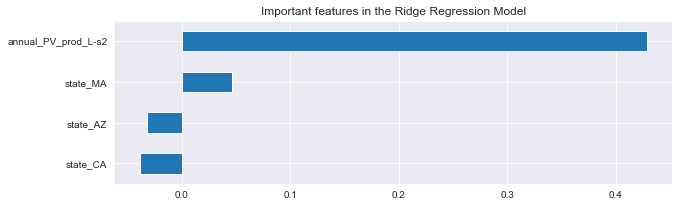

In [24]:
# Plot important coefficients
coefs = pd.Series(rg.coef_, index = solar1.columns)

print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(2), coefs.sort_values().tail(2)])
imp_coefs.plot(kind = "barh", figsize=(10, 3))
plt.title("Important features in the Ridge Regression Model")
plt.show()

→ `annual_PV_prod`'s derrivative is the most important feature for prediction, comply with the hypothesis

#### Ridge regression performance with validation set

In [25]:
y_pred = rg.predict(solar_val_stndz)
print(f'Ridge Regression_r2_Validation_set: {rg.score(solar_val_stndz, y_val_L).round(6)}')
print(f'Ridge Regression_mean_squared_error: {mean_squared_error(y_val_L, y_pred).round(6)}')

cv_score = cross_val_score(rg, solar_val_stndz, y_val_L, cv=kf)
print(f'Overall model performance with cv_Mean_r2: {cv_score.mean().round(4)}', '\n'
f'Overall model performance with cv_Std_deviation_r2: {cv_score.std().round(6)}')

Ridge Regression_r2_Validation_set: 0.985611
Ridge Regression_mean_squared_error: 0.002683
Overall model performance with cv_Mean_r2: 0.9856 
Overall model performance with cv_Std_deviation_r2: 0.000382


→ **Next step**: The characteristic of ridge regression is that it reduces the coefficient close to 0 but NOT 0, thus it can't act as a feature selector unlike Lasso regression. Lasso helps to remove unwanted features. As we know there are some features which might not be very important to predict `size_kw` we should try Lasso.

## 3.A.4. Linear Regression with Lasso regularization (L1 penalty)

In [26]:
# Regularized regression(lasso) without any tuning
ls = Lasso(alpha=1)
ls.fit(X_train, y_train)

print(f'Lasso Regression_r2: {ls.score(X_test, y_test).round(4)}')
cv_score = cross_val_score(ls, solar1_stndz, y_L, cv=kf)
print(f'Overall model performance with cv_Mean: {cv_score.mean().round(4)}', '\n'
f'Overall model performance with cv_Std_deviation: {cv_score.std().round(6)}')

Lasso Regression_r2: -0.0
Overall model performance with cv_Mean: -0.0 
Overall model performance with cv_Std_deviation: 1.5e-05


Lasso performs poorly (penalty is too strong), we need to tune the `alpha` hyperparameter of lasso to improve its performance.

#### Lasso regression hyperparameter tuning

In [27]:
# Regularized regression(lasso) with hyperparameter tuning
alphas = [ 1e-06,  1e-05,  1e-04,  1e-03,  1e-02,  1e-01, 1]
param_grid = {'alpha': alphas}
gs = GridSearchCV(ls, param_grid, cv=kf)
gs.fit(solar1_stndz, y_L)
print(f'best_score: {(gs.best_score_).round(6)}')
lasso_best_alpha = gs.best_params_['alpha']
print(f'Lasso_best_alpha: {lasso_best_alpha}')

# Regularized regression(lasso) with tuning
ls = Lasso(alpha = lasso_best_alpha)
ls.fit(X_train, y_train)
print(f'Lasso Regression_r2: {rg.score(X_test, y_test).round(4)}')
cv_score = cross_val_score(ls, solar1_stndz, y_L, cv=kf)
print(f'Overall model performance with cv_Mean: {cv_score.mean().round(4)}', '\n'
f'Overall model performance with cv_Std_deviation: {cv_score.std().round(6)}')

best_score: 0.98585
Lasso_best_alpha: 1e-06
Lasso Regression_r2: 0.9859
Overall model performance with cv_Mean: 0.9858 
Overall model performance with cv_Std_deviation: 9.8e-05


#### Impact of alpha strength on the coefficient of the features in Lasso Regression 

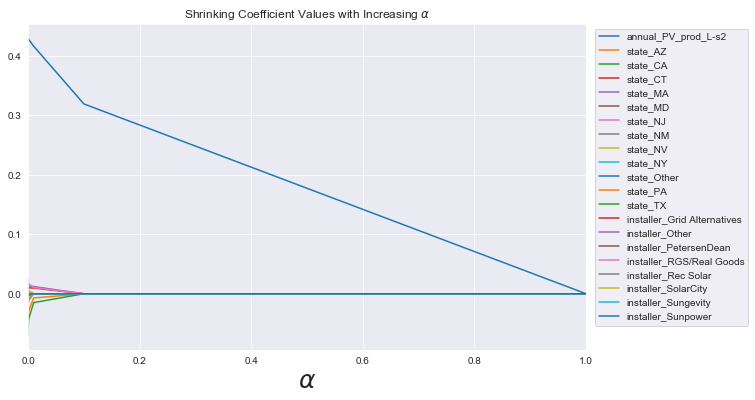

In [28]:
coefs = [] 
for alpha in alphas:
    ls = Lasso(alpha=alpha)
    ls.fit(X_train, y_train)
    coefs.append(ls.coef_)
df_coef = pd.DataFrame(index=alphas, data=np.array(coefs), columns=solar1.columns)

ax = df_coef.iloc[:950,:21].plot(figsize=(10, 6), title=r'Shrinking Coefficient Values with Increasing $\alpha$')
ax.legend(bbox_to_anchor=(1.3, 1))
ax.set_xlabel(r'$\alpha$', size=25);

#### Feature importance based on Lasso regression

Lasso picked 76 features and eliminated the other 2 features


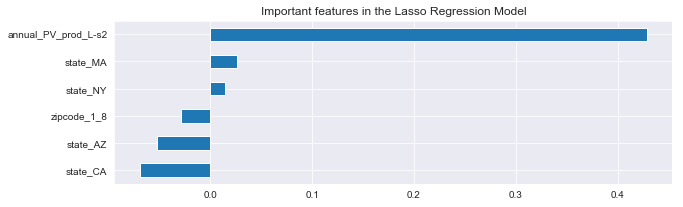

In [29]:
# Plot important coefficients
ls = Lasso(alpha = 1e-06)
ls.fit(X_train, y_train)
coefs = pd.Series(ls.coef_, index = solar1.columns)

print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(3), coefs.sort_values().tail(3)])
imp_coefs.plot(kind = "barh",figsize=(10, 3))
plt.title("Important features in the Lasso Regression Model")
plt.show()

→ `annual_PV_prod`'s derrivative is the most important feature for prediction, comply with the hypothesis

#### Lasso regression performance with validation set

In [30]:
ls = Lasso(alpha = lasso_best_alpha)
ls.fit(X_train, y_train)
y_pred = ls.predict(solar_val_stndz)
print(f'Lasso Regression_r2_Validation_set: {ls.score(solar_val_stndz, y_val_L).round(6)}')
print(f'Lasso Regression_mean_squared_error: {mean_squared_error(y_val_L, y_pred).round(6)}')

cv_score = cross_val_score(ls, solar_val_stndz, y_val_L, cv=kf)
print(f'Overall model performance with cv_Mean_r2: {cv_score.mean().round(4)}', '\n'
f'Overall model performance with cv_Std_deviation_r2: {cv_score.std().round(6)}')

Lasso Regression_r2_Validation_set: 0.985611
Lasso Regression_mean_squared_error: 0.002683
Overall model performance with cv_Mean_r2: 0.9856 
Overall model performance with cv_Std_deviation_r2: 0.000382


►**Overall summary**<br>
→ Lasso regression performs poorly without hyperparameter tuning.<br>

→ As alpha is tuned, lasso performance improves greatly. But for a good prediction we have to keep alpha very low, thus coefficients will not be penalized harshly and thus only few features will be eliminated. Additionaly, Lasso prediction performance is similar to ridge, so we can use ridge model as the final model.<br>

In [31]:
# Save the model, for ridge alpha=1 performed well
rg = Ridge(alpha=1)
rg.fit(X_train, y_train)
from sklearn.externals import joblib
joblib.dump(rg, 'size_prediction_model.joblib');

# 4.A. Predictive modeling for solar panels cost

In [32]:
# dependent variable 
y_L = solar['cost_L']
y_val_L = solar_val['cost_L']

# independent variables
cols2 = ['cost', 'cost_L', 'size_kw_L', 'zipcode', 'annual_PV_prod', 'date_installed', 'annual_PV_prod_L-s2']
solar2 = solar.drop(columns=cols2) 
solar_val2 = solar_val.drop(columns=cols2)                       

### Machine Learning Pipeline

#### **Making a PIPELINE with BOTH NUMERIC and CATEGORICAL columns separately**<br>
**STEPS**:
* `ColumnTransformer` will be used to create two pipelines that transform the numeric and categorical features separately. 
* We then create another pipeline hooking up this pipeline with a machine learning model.

In [33]:
# Separate into numerical and categorical columns
num_col = solar2.select_dtypes('number').columns.tolist()
cat_col = solar2.select_dtypes('object').columns.tolist()

In [34]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import Ridge 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [35]:
# Numeric column pipeline
#si = SimpleImputer(strategy='median')
ss = StandardScaler()
steps = [('scale', ss)] #('impute', si), 
numeric_pipe = Pipeline(steps)

# Categorical column pipeline
#si = SimpleImputer(strategy='constant', fill_value='UNKNOWN')
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
steps = [('ohe', ohe)] #('impute', si), 
cat_pipe = Pipeline(steps)

# Transform both Numeric and Categorical columns
transformers = [('numeric_pipe', numeric_pipe, num_col), ('cat_pipe', cat_pipe, cat_col)]
ct = ColumnTransformer(transformers)
# Save transformed data
X = ct.fit_transform(solar2)

# ML in the final pipeline
rg = Ridge(alpha=1)
final_pipe = Pipeline([('ct', ct), ('rg', rg)])

# Performance without hyperparameter tuning
final_pipe.fit(solar2, y_L)
kf = KFold(n_splits=5, shuffle=True, random_state=0)
cv_scores = cross_val_score(final_pipe, solar2, y_L, cv=kf)
print(f'Ridge regression performance without hyperparameter tuning')
print(f'cross-val score_r2: {cv_scores.mean().round(4)}, standard deviation: {cv_scores.std().round(6)}')

# Performance with validation set
# final_pipe.fit(solar2, y_L)
print(f'Validation set_R2: {final_pipe.score(solar_val2, y_val_L).round(4)}')
cv_scores = cross_val_score(final_pipe, solar_val2, y_val_L, cv=kf)
print(f'Validation set cross-val score_r2: {cv_scores.mean().round(4)}, standard deviation: {cv_scores.std().round(6)}')

Ridge regression performance without hyperparameter tuning
cross-val score_r2: 0.7979, standard deviation: 0.002245
Validation set_R2: 0.7905
Validation set cross-val score_r2: 0.7966, standard deviation: 0.002426


**Let's try to improve R2 by hyperparameter tuning**

In [36]:
grid = {'rg__alpha': np.logspace(-3, 3, 1000)} 
gs = GridSearchCV(final_pipe, grid, cv=kf)
gs.fit(solar2, y_L)
print(f'Ridge regression performance after hyperparameter tuning')
print(f'best_score: {(gs.best_score_).round(6)}')
ridge_best_alpha = gs.best_params_['rg__alpha']
print(f'ridge_best_alpha: {ridge_best_alpha.round(6)}')

# Regularized regression(lasso) after tuning
rg = Ridge(alpha = ridge_best_alpha)
final_pipe1 = Pipeline([('ct', ct), ('rg', rg)])
# Performance with hyperparameter tuning
cv_scores = cross_val_score(final_pipe1, solar2, y_L, cv=kf)
print(f'cross-val score_r2: {cv_scores.mean().round(4)}, standard deviation: {cv_scores.std().round(6)}')

# Peformance with validation set 
cv_scores = cross_val_score(final_pipe1, solar_val2, y_val_L, cv=kf)
print(f'Validation set cross-val score_r2: {cv_scores.mean().round(4)}, standard deviation: {cv_scores.std().round(6)}')

Ridge regression performance after hyperparameter tuning
best_score: 0.797852
ridge_best_alpha: 1.124737
cross-val score_r2: 0.7979, standard deviation: 0.002245
Validation set cross-val score_r2: 0.7966, standard deviation: 0.002426


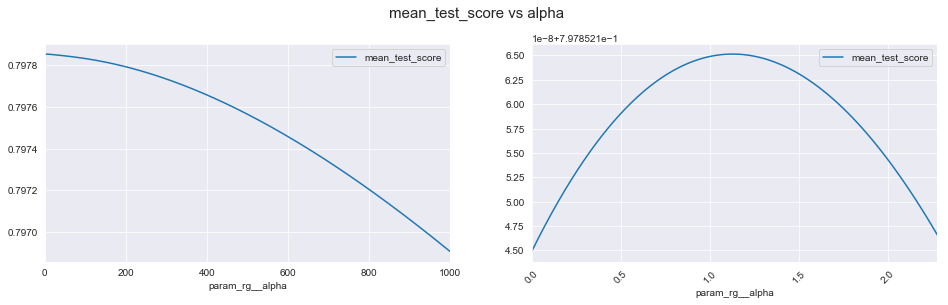

In [37]:
# Plot to show how alpha(penalty) impacts model performance
df_results = pd.DataFrame(gs.cv_results_)
fig, axes = plt.subplots(1,2, figsize = (16,4))
df_results.plot(x='param_rg__alpha', y='mean_test_score', ax=axes[0])
df_results[:560].plot(x='param_rg__alpha', y='mean_test_score', ax=axes[1]) 
axes[1].xaxis.set_tick_params(rotation=45)
fig.suptitle('mean_test_score vs alpha', fontsize=15, y=1.01);

As penalty increases performance improves and after that with more stronger penalty, performance reduces due to weight of the penalty.

In [38]:
# Import joblib and save the model to disk
from sklearn.externals import joblib
final_pipe.fit(solar2, y_L)
joblib.dump(final_pipe, 'cost_prediction_pipeline.joblib');

**Overall summary**<br>
■ We built a ridge regression model with R2 ~98.5% for predicting solar panel size. <br>
■ We built the ML pipeline with ridge regression to predict cost of solar panels (R2 of ~80%). In case of both models, CV showed limited standard deviation, and the model is saved to disk.<br>
■ In part 2 of the notebook we will focus on conceiving a data-product idea, where an user can give his energy usage and his/her location (zipcode, county, city etc) to get predicted size of solar panels needed, and predicted cost of the solar panels.